# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

### To think about

Here are a few things to think and try out about before the next laboratory.

1. Is looking at the max logit the *best* we can do using *just* the CNN outputs? Is there maybe a better way to try to gauge model *confidence* from the logits?

2. Does the behavior of the network on OOD data get *better* or *worse* with more (or fewer) training epochs?

2. Does the problem get worse if we test using *real* images as OOD samples? Find a subset of CIFAR-100 classes that are *distinct* from those in CIFAR-10 and test this theory.


In [1]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torch.utils.data import Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
import random
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 4 if device == 'cpu' else 8

In [3]:
def train_epoch(model, dataloader, criterion, optimizer, epoch='Unknown', device='cpu', fully_conv=False):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if fully_conv:
            _, _, a, b = outputs.shape
            gts = labels.unsqueeze(-1).unsqueeze(-1).repeat(1,a,b)
            loss = criterion(outputs, gts)
        else:
          loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    return avg_loss


def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.eval()
    losses = []
    predictions = []
    gts = []
    with torch.no_grad():
        for (inputs, labels) in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            gts.append(labels.cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())
            losses.append(loss.item())
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(np.hstack(gts), np.hstack(predictions))
    report = classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3)
    return avg_loss, accuracy, report


def plot_validation_curves(losses_and_accs, fig_path):
    train_losses = [x for (x, _, _) in losses_and_accs]
    val_losses = [x for (_, x, _) in losses_and_accs]
    accs = [x for (_, _, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {round(np.max(accs), 2)} @ epoch {np.argmax(accs)}')
    plt.savefig(fig_path)

In [49]:
ood = 'fakedata'

In [17]:
ood = 'cifar100'

In [50]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

batch_size = 256

id_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

if ood == 'fakedata':
  fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
  fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

if ood == 'cifar100':
  ood_classes = ["aquarium", "bycicle", "bottle", "bed", "rocket", "can", "girl", "chair"]
  cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
  selected_indices = [i for i, (_, label) in enumerate(cifar100) if cifar100.classes[label] in ood_classes]
  fakeset = Subset(cifar100, selected_indices)
  fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


## Architecture

In [24]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
model = CNN().to(device)
loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 50
for e in range(epochs):
    train_epoch(model, trainloader, loss, optimizer, epoch=e, device=device)
    val_loss, val_acc, val_report = evaluate_model(model, testloader, loss, device=device)
    print(f'Epoch {e} - Validation Loss: {val_loss} - Validation Accuracy: {val_acc}')


In [28]:
torch.save(model.state_dict(), './trained_models/cifar10_cnn_n.pth')

In [64]:
# PRETRAINED CUSTOM CNN.
model = CNN().to(device)
model.load_state_dict(torch.load('./trained_models/cifar10_cnn_n.pth', map_location=device)) #50 epochs

<ipython-input-64-96dae364d77d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./trained_models/cifar10_cnn_n.pth', map_location=device))

<All keys matched successfully>

In [51]:
# PRETRAINED RESNET
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [65]:
_, test_acc, report = evaluate_model(model, testloader, loss, device=device)
print(f'Test Accuracy: {test_acc}')
print(report)
# CNN 0.7147
# CNN2 0.7012
# ResNet 0.9260

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                                           

Test Accuracy: 0.7012
              precision    recall  f1-score   support

           0      0.752     0.741     0.747      1000
           1      0.859     0.770     0.812      1000
           2      0.561     0.642     0.599      1000
           3      0.535     0.493     0.513      1000
           4      0.619     0.677     0.647      1000
           5      0.594     0.590     0.592      1000
           6      0.795     0.748     0.771      1000
           7      0.715     0.761     0.737      1000
           8      0.840     0.793     0.816      1000
           9      0.783     0.797     0.790      1000

    accuracy                          0.701     10000
   macro avg      0.705     0.701     0.702     10000
weighted avg      0.705     0.701     0.702     10000



## Compute Score

tensor(3, device='cuda:0')


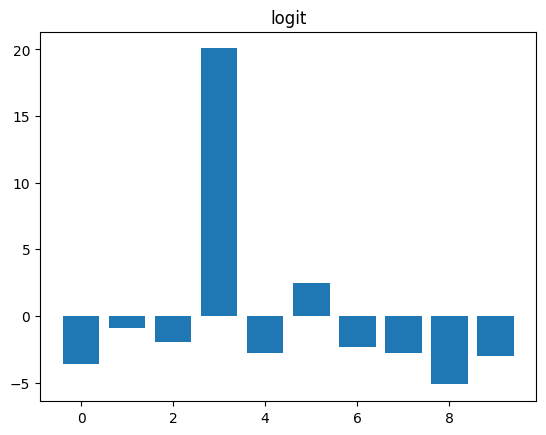

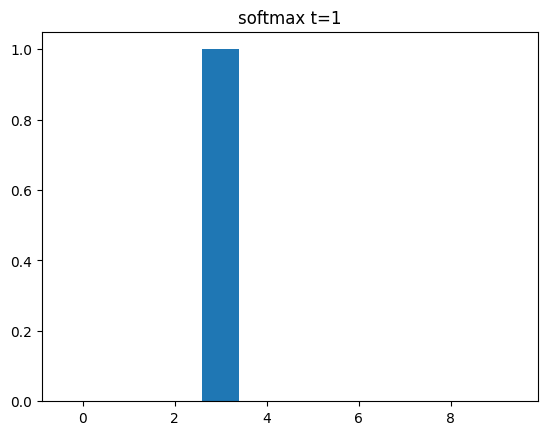

In [ ]:
#Example of logit and softmax output with ID data
x, y = next(iter(testloader))
x, y = x.to(device), y.to(device)
print(y[0])
output = model(x)
plt.bar(np.arange(10),output[0].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[0].detach().cpu())
plt.show()

In [32]:
def max_logit(logit):
    s, _ = logit.max(dim=1) #get the max for each element of the batch
    return s

# (A BASELINE FOR DETECTING MISCLASSIFIED AND OUT-OF-DISTRIBUTION EXAMPLES IN NEURAL NETWORKS, https://arxiv.org/pdf/1610.02136)
def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s, _ = s.max(dim=1) #get the max for each element of the batch
    return s

def compute_scores(data_loader, score_function):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_function(output)
            scores.append(s.cpu())
        scores_t = torch.cat(scores)
        return scores_t


In [66]:
score_function = max_softmax

scores_test = compute_scores(testloader, score_function)
scores_fake = compute_scores(fakeloader, score_function)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


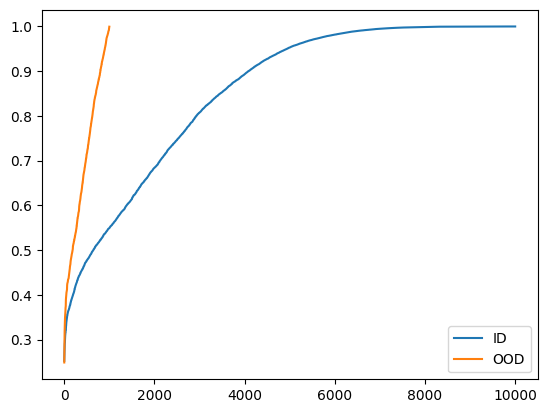

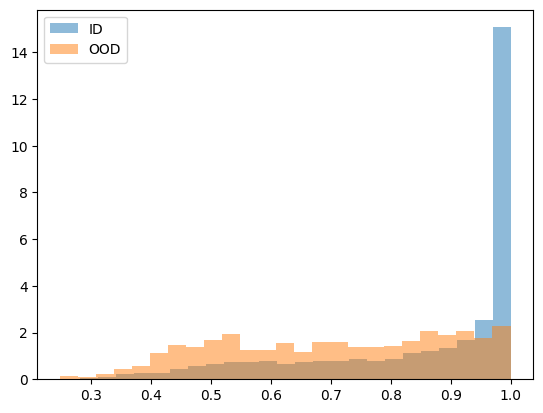

In [67]:
plt.figure()
plt.plot(sorted(scores_test), label='ID')
plt.plot(sorted(scores_fake), label='OOD')
plt.legend()

plt.figure()
plt.hist(scores_test, density=True, alpha=0.5, bins=25, label='ID')
plt.hist(scores_fake, density=True, alpha=0.5, bins=25, label='OOD')
plt.legend()
plt.show()

## Autoencoder MSE

In [45]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [46]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [ ]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.39966922017688655
1 0.2221485208339837
2 0.20611703608717238
3 0.1982143470371256
4 0.1913501812639285
5 0.184052690787583
6 0.17727649021817712
7 0.17266274456466948
8 0.16983512766203102
9 0.16788785319243157
10 0.16628853718237002
11 0.16474854345528447
12 0.1633074075287702
13 0.16190840281089958
14 0.1605105532371268
15 0.15969771298826957
16 0.1590011543309202
17 0.1583386223231043
18 0.15777625325991182
19 0.15735288504130987


In [ ]:
torch.save(model_ae.state_dict(), './trained_models/cifar10_ae.pth')

In [47]:
model_ae.load_state_dict(torch.load('./trained_models/cifar10_ae.pth', map_location=device))

<ipython-input-47-555138f9ddea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ae.load_state_dict(torch.load('./trained_models/cifar10_ae.pth', map_location=device))

<All keys matched successfully>

In [48]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)

scores_fake_ae = torch.cat(scores_fake_ae)

scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)

scores_test_ae = torch.cat(scores_test_ae)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


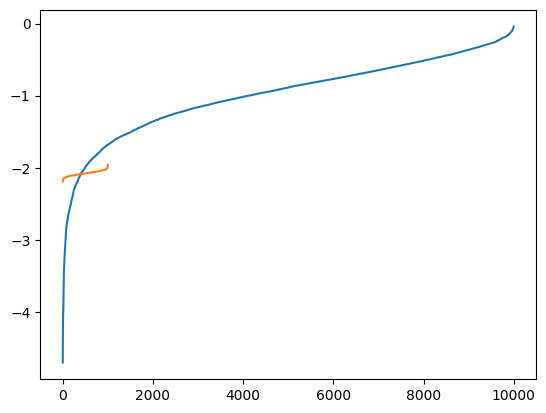

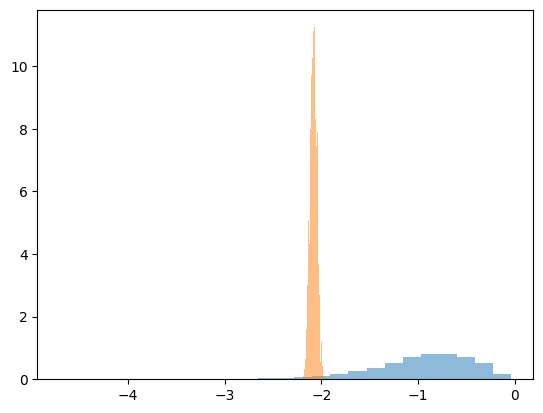

In [49]:
plt.figure()
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))

plt.figure()
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



AUC ROC: 0.7515789499999999
FPR at 95% TPR: 0.855
AUC PRC: 0.970058290233382
Precision: 0.9090909090909091
Recall: 1.0


'\nCNN\nAUC ROC: 0.61979655\nFPR at 95% TPR: 0.992\nAUC PRC: 0.9513096605860426\n\nRESNET\nAUC ROC: 0.9497987999999999\nFPR at 95% TPR: 0.417\nAUC PRC: 0.995021479796409\n\nAUTOENCODER\nAUC baseline: 0.9589767499999999\nFPR at 95% TPR: 0.004\nAUC OOD: 0.9961815253879001\n'

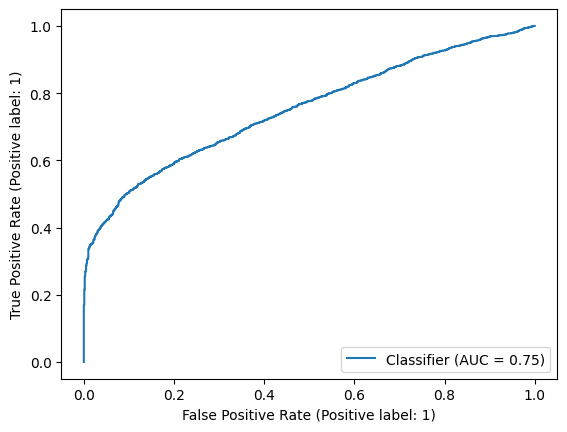

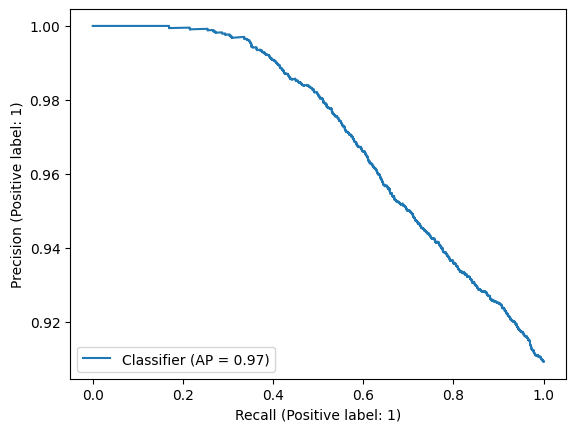

In [68]:
prediction = torch.cat((scores_test, scores_fake))
target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))

fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
auc_score = metrics.auc(fpr, tpr)
print(f'AUC ROC: {auc_score}')
tpr_95_index = np.argmin(np.abs(tpr - 0.95))
fpr_at_95_tpr = fpr[tpr_95_index]
print(f'FPR at 95% TPR: {fpr_at_95_tpr}')
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

precision, recall, _ = metrics.precision_recall_curve(target.cpu().numpy(), prediction.cpu().numpy())
print(f'AUC PRC: {metrics.auc(recall, precision)}')
print(f'Precision: {precision[recall.argmax()]}')
print(f'Recall: {recall[recall.argmax()]}')
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

# CIFAR-100
'''
CNN
AUC ROC: 0.6912194833333333
FPR at 95% TPR: 0.8846666666666667
AUC PRC: 0.8883838977374949

RESNET
AUC ROC: 0.7904088666666667
FPR at 95% TPR: 0.813
AUC PRC: 0.9272905113173147

AUTOENCODER
'''

# FAKE

'''
CNN
AUC ROC: 0.7515789499999999
FPR at 95% TPR: 0.855
AUC PRC: 0.970058290233382

RESNET
AUC ROC: 0.9497987999999999
FPR at 95% TPR: 0.417
AUC PRC: 0.995021479796409

AUTOENCODER
AUC baseline: 0.9589767499999999
FPR at 95% TPR: 0.004
AUC OOD: 0.9961815253879001
'''

AUC baseline: 0.9589767499999999
FPR at 95% TPR: 0.004
AUC OOD: 0.9961815253879001
Precision: 0.9090909090909091
Recall: 1.0


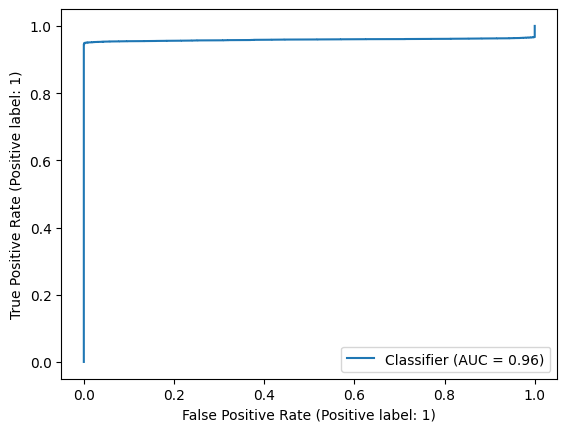

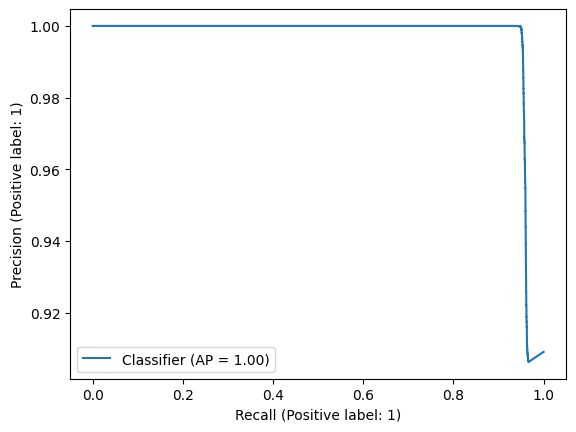

In [50]:
prediction = torch.cat((scores_test_ae, scores_fake_ae))
target = torch.cat((torch.ones_like(scores_test_ae), torch.zeros_like(scores_fake_ae)))

fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
auc_score = metrics.auc(fpr, tpr)
print(f'AUC baseline: {auc_score}')
tpr_95_index = np.argmin(np.abs(tpr - 0.95))
fpr_at_95_tpr = fpr[tpr_95_index]
print(f'FPR at 95% TPR: {fpr_at_95_tpr}')
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

precision, recall, _ = metrics.precision_recall_curve(target.cpu().numpy(), prediction.cpu().numpy())
print(f'AUC OOD: {metrics.auc(recall, precision)}')
print(f'Precision: {precision[recall.argmax()]}')
print(f'Recall: {recall[recall.argmax()]}')
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [16]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [18]:
def fgsm_attack(model, criterion, image, label, epsilon, max_iter=100):
    orig_img = image.clone().detach()
    perturb_img = image.clone().detach().requires_grad_(True)

    output = model(perturb_img.unsqueeze(0))
    if output.argmax().item() != label.item():
        return 0, orig_img, perturb_img.detach(), output.argmax().item()
    for i in range(max_iter + 1):
        output = model(perturb_img.unsqueeze(0))
        loss = criterion(output, label.unsqueeze(0))
        pred = output.argmax().item()
        if pred != label.item():
            return i, orig_img, perturb_img.detach(), pred

        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturb_img += epsilon * torch.sign(perturb_img.grad)

        perturb_img.requires_grad_(True)

    return None, orig_img, perturb_img.detach(), pred


def show_attack(orig_img, label, adv_img, pred, num_iter, inv, classes):
    if num_iter == None:
        print('Attack Failed!')
    elif num_iter == 0:
        print('Already misclassified!')
    else:
        print(f'Attack Success!')
        print(f'Iteration: {num_iter}')
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(inv(orig_img).permute(1,2,0).detach().cpu())
        ax[0].set_title(f'Original - {classes[label]}')
        ax[1].imshow(inv(adv_img).permute(1,2,0).detach().cpu())
        ax[1].set_title(f'Adversarial - {classes[pred]}')
        ax[2].imshow(inv(orig_img-adv_img).permute(1,2,0).detach().cpu())
        ax[2].set_title('Difference')
        plt.show()


Already misclassified!
Attack Success!
Iteration: 1


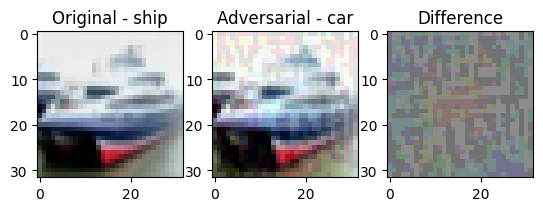

Attack Success!
Iteration: 1


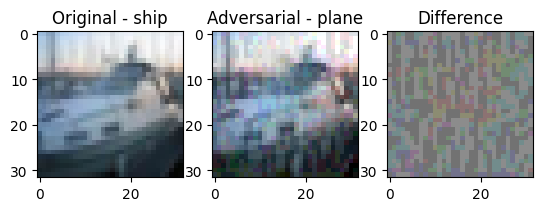

Attack Success!
Iteration: 1


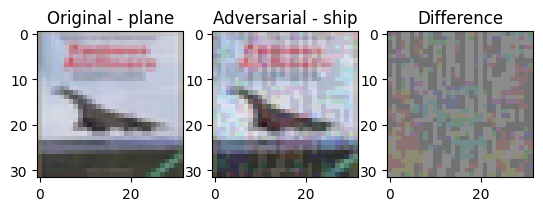

Already misclassified!
Attack Success!
Iteration: 1


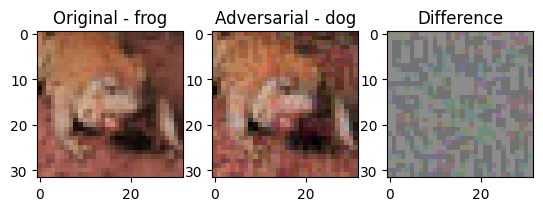

Already misclassified!
Attack Success!
Iteration: 1


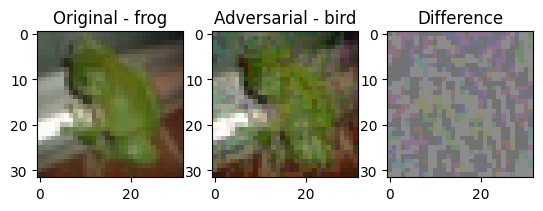

Attack Success!
Iteration: 1


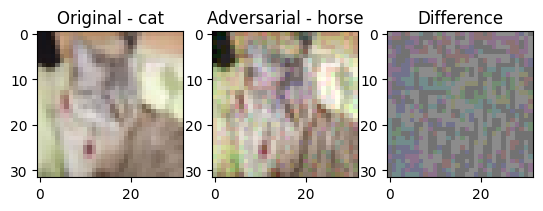

Attack Success!
Iteration: 1


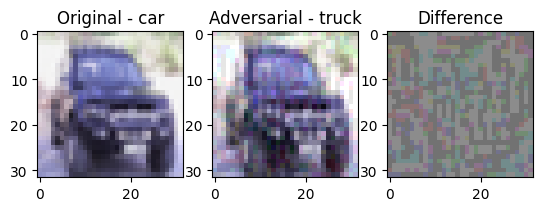

Attack Success!
Iteration: 1


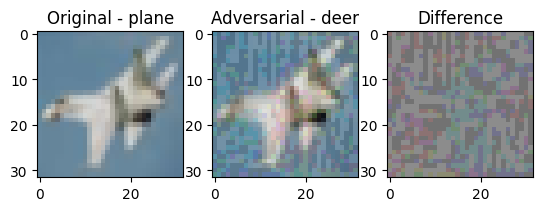

Attack Success!
Iteration: 1


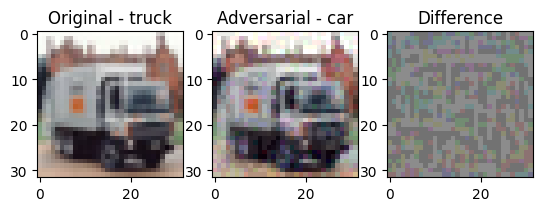

Attack Success!
Iteration: 1


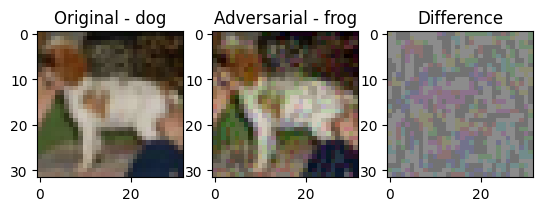

Attack Success!
Iteration: 1


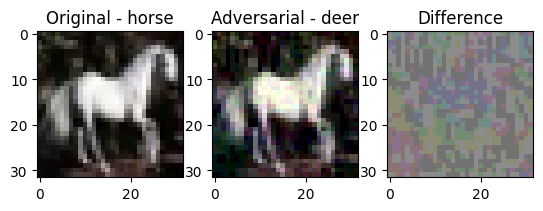

Attack Success!
Iteration: 1


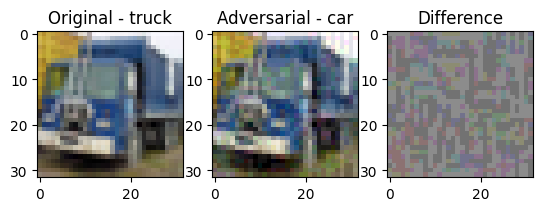

Attack Success!
Iteration: 1


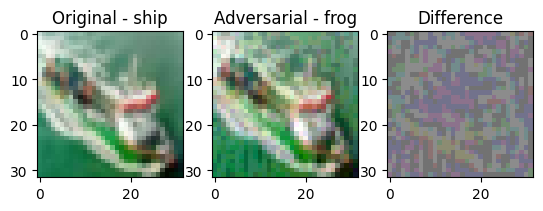

In [20]:
epsilon = 0.1
batch_size = 16
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model.eval()

img, label = next(iter(testloader))
for i in range(batch_size):
    img_ex, label_ex = img[i].to(device), label[i].to(device)
    num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img_ex, label_ex, epsilon)
    show_attack(orig_img, label_ex, adv_img, pred, num_iter, inv, classes)


In [ ]:
# EVALUATE ASR VERSUS EPSILON
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_eps = []
for epsilon in epsilons:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=1)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_eps.append(num_success/num_attacks)
    print(f'Epsilon: {epsilon} - Attack Success Rate: {num_success/num_attacks}')


Files already downloaded and verified
Epsilon: 0.001 - Attack Success Rate: 0.030789825970548863
Epsilon: 0.005 - Attack Success Rate: 0.12605042016806722
Epsilon: 0.01 - Attack Success Rate: 0.2751031636863824
Epsilon: 0.02 - Attack Success Rate: 0.5319148936170213
Epsilon: 0.05 - Attack Success Rate: 0.8843441466854725
Epsilon: 0.1 - Attack Success Rate: 0.9817415730337079


In [ ]:
#EVALUATE ASR VERSUS MAX ITERATIONS
epsilon = 0.001
max_iters = [1, 5, 10, 20, 50]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_iters = []
for max_iter in max_iters:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=max_iter)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_iters.append(num_success/num_attacks)
    print(f'Max Iters: {max_iter} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified
Epsilon: 0.001 - Attack Success Rate: 0.02145922746781116
Epsilon: 0.001 - Attack Success Rate: 0.1643059490084986
Epsilon: 0.001 - Attack Success Rate: 0.28005657708628007
Epsilon: 0.001 - Attack Success Rate: 0.5463483146067416
Epsilon: 0.001 - Attack Success Rate: 0.9516358463726885


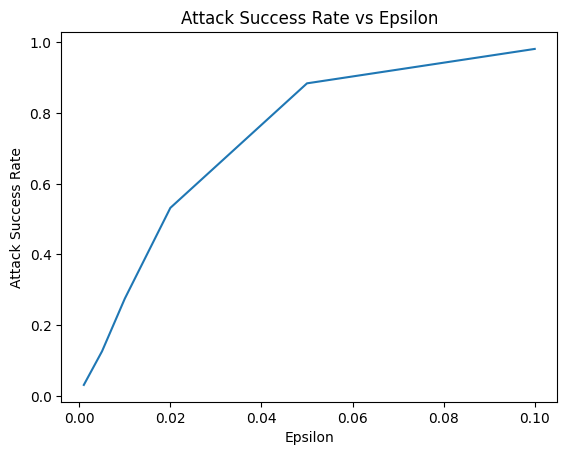

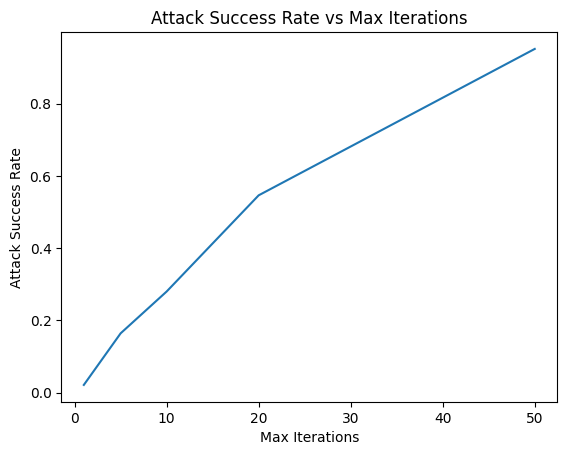

In [ ]:
plt.figure()
plt.plot(epsilons, asr_eps)
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Epsilon')

plt.figure()
plt.plot(max_iters, asr_iters)
plt.xlabel('Max Iterations')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Max Iterations')
plt.show()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
def train_epoch_adv(model, dataloader, loss_fn, optimizer, epoch=0, device='cpu', epsilon=0.01):
  model.train()
  train_loss = []
  bar = tqdm(dataloader, total=len(dataloader))

  for i, (x, y) in enumerate(bar):
    x, y = x.to(device), y.to(device)

    #generate adversarial examples
    x_adv = x.clone().detach().requires_grad_(True)
    for _ in range(1):
      output = model(x_adv)
      loss = loss_fn(output, y)
      model.zero_grad()
      loss.backward()
      with torch.no_grad():
        x_adv += epsilon * torch.sign(x_adv.grad)
      x_adv.requires_grad_(True)

    #train on adversarial examples
    optimizer.zero_grad()
    output_adv = model(x_adv.detach())
    loss_adv = loss_fn(output_adv, y)
    loss_adv.backward()
    optimizer.step()

    #train on original data
    optimizer.zero_grad()
    output = model(x)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    bar.set_description(f"Epoch {epoch} loss: {np.mean(train_loss):.5f}")
  return np.mean(train_loss)


In [ ]:
#train the model with adversarial training
model = CNN().to(device)
loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50
epsilon = 0.01

for e in range(epochs):
  train_loss = train_epoch_adv(model, trainloader, loss, optimizer, epoch=e, device=device, epsilon=epsilon)
  val_loss, val_acc, val_report = evaluate_model(model, testloader, loss, device=device)
  print(f'Epoch {e} - Validation Loss: {val_loss} - Validation Accuracy: {val_acc}')

In [ ]:
# EVALUATE ASR VERSUS EPSILON
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_eps_adv = []
for epsilon in epsilons:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=1)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_eps_adv.append(num_success/num_attacks)
    print(f'Epsilon: {epsilon} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epsilon: 0.001 - Attack Success Rate: 0.015895953757225433
Epsilon: 0.005 - Attack Success Rate: 0.10953058321479374
Epsilon: 0.01 - Attack Success Rate: 0.2233285917496444
Epsilon: 0.02 - Attack Success Rate: 0.4014285714285714
Epsilon: 0.05 - Attack Success Rate: 0.7406340057636888
Epsilon: 0.1 - Attack Success Rate: 0.875


In [ ]:
#EVALUATE ASR VERSUS MAX ITERATIONS
epsilon = 0.001
max_iters = [1, 5, 10, 20, 50]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_iters_adv = []
for max_iter in max_iters:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=max_iter)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_iters_adv.append(num_success/num_attacks)
    print(f'Max Iterations: {max_iter} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max Iterations: 1 - Attack Success Rate: 0.023633677991137372
Max Iterations: 5 - Attack Success Rate: 0.10241820768136557
Max Iterations: 10 - Attack Success Rate: 0.212298682284041
Max Iterations: 20 - Attack Success Rate: 0.41944847605224966
Max Iterations: 50 - Attack Success Rate: 0.8269794721407625


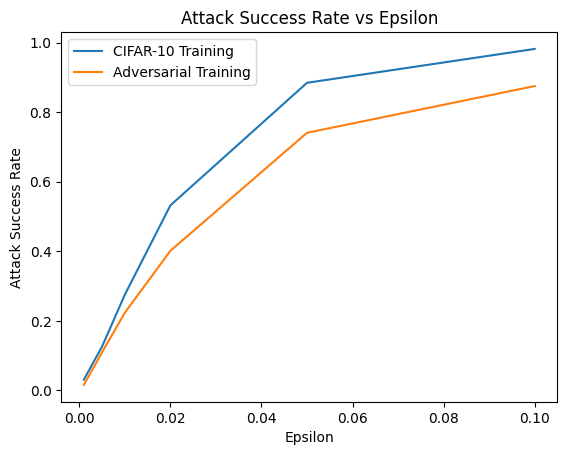

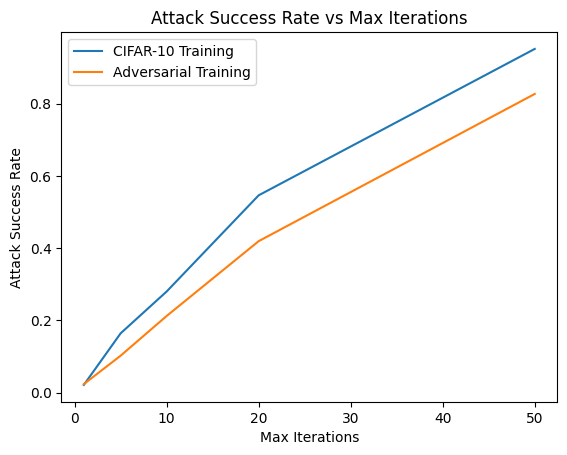

In [ ]:
plt.figure()
plt.plot(epsilons, asr_eps, label='CIFAR-10 Training')
plt.plot(epsilons, asr_eps_adv, label='Adversarial Training')
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Epsilon')
plt.legend()

plt.figure()
plt.plot(max_iters, asr_iters, label='CIFAR-10 Training')
plt.plot(max_iters, asr_iters_adv, label='Adversarial Training')
plt.xlabel('Max Iterations')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Max Iterations')
plt.legend()
plt.show()

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.  
**Note:** I did ex 3.1 and 3.3

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

In [72]:
# Implementation of ODIN

class Odin():
    def __init__(self, model, temperature=1, epsilon=0.01):
        self.model = model
        self.temperature = temperature
        self.epsilon = epsilon

    def __call__(self, inputs):
        return self.detect(inputs)

    def set_temperature(self, temperature):
        self.temperature = temperature

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def input_preprocessing(self, inputs, gradient):
        return inputs - self.epsilon * gradient.sign()

    def compute_gradient(self, inputs):
        inputs.requires_grad = True
        logits = self.model(inputs)
        logits = logits / self.temperature
        max_logit, _ = torch.max(logits, dim=1)
        model.zero_grad()
        max_logit.backward(torch.ones(max_logit.shape, device=max_logit.device))
        gradient = -inputs.grad
        return gradient

    def compute_scores(self, inputs):
        gradient = self.compute_gradient(inputs)
        gradient = gradient.detach()
        preprocessed_inputs = self.input_preprocessing(inputs, gradient)

        with torch.no_grad():
            logits = model(preprocessed_inputs)
            softmax_scores = F.softmax(logits / self.temperature, dim=1)
            max_softmax_scores, _ = torch.max(softmax_scores, dim=1)

        return max_softmax_scores

    def detect(self, dataloader):
        scores = []
        model.eval()
        for (x, y) in dataloader:
            x = x.to(device)
            score = self.compute_scores(x)
            scores.append(score.cpu())
            del x, score
            torch.cuda.empty_cache()
            gc.collect()
        scores_t = torch.cat(scores)
        return scores_t

In [73]:
def grid_search(model, testloader, fakeloader, temperatures, epsilons, device='cpu'):
    model.eval()
    odin = Odin(model)
    best_auc = 0
    best_temp = None
    best_eps = None
    for temp in temperatures:
        for eps in epsilons:
            odin.set_temperature(temp)
            odin.set_epsilon(eps)
            scores_test = odin(testloader)
            scores_fake = odin(fakeloader)
            prediction = torch.cat((scores_test, scores_fake))
            target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))
            fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
            auc_score = metrics.auc(fpr, tpr)
            if auc_score > best_auc:
                print(f'Temperature: {temp}, Epsilon: {eps}, AUC: {auc_score}')
                best_auc = auc_score
                best_temp = temp
                best_eps = eps
    return best_temp, best_eps, best_auc

In [ ]:
temperatures = [1, 10, 20, 50, 100, 200, 500]
epsilons = [0.01, 0.02, 0.03, 0.04]
best_temp, best_eps, best_auc = grid_search(model, testloader, fakeloader, temperatures, epsilons, device=device)
print(f'Best Temp: {best_temp}')
print(f'Best Eps: {best_eps}')
print(f'Best AUC: {best_auc}')

In [69]:
# FAKE DATA
temp = 10
eps = 0.01

In [20]:
# CIFAR-100
temp = 10
eps = 0.01

In [70]:
odin = Odin(model, temperature=temp, epsilon=eps)
scores_test_odin = odin(testloader)
scores_fake_odin = odin(fakeloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
prediction = torch.cat((scores_test_odin, scores_fake_odin))
target = torch.cat((torch.ones_like(scores_test_odin), torch.zeros_like(scores_fake_odin)))
fpr_odin, tpr_odin, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
auc_score = metrics.auc(fpr, tpr)
print(f'AUC ROC: {auc_score}')
tpr_95_index = np.argmin(np.abs(tpr - 0.95))
fpr_at_95_tpr = fpr[tpr_95_index]
print(f'FPR at 95% TPR: {fpr_at_95_tpr}')
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

precision_odin, recall_odin, _ = metrics.precision_recall_curve(target.cpu().numpy(), prediction.cpu().numpy())
print(f'AUC PRC: {metrics.auc(recall, precision)}')
print(f'Precision: {precision[recall.argmax()]}')
print(f'Recall: {recall[recall.argmax()]}')
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

# CIFAR-100
'''
CNN


RESNET
AUC ROC: 0.8806609333333334
FPR at 95% TPR: 0.5056666666666667
AUC PRC: 0.9567345521024009
'''

# FAKE DATA
'''
CNN


RESNET
AUC ROC: 0.9995837
FPR at 95% TPR: 0.0
AUC PRC: 0.9999591079293224
'''

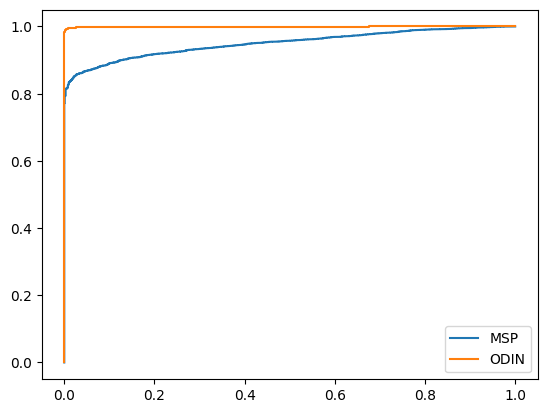

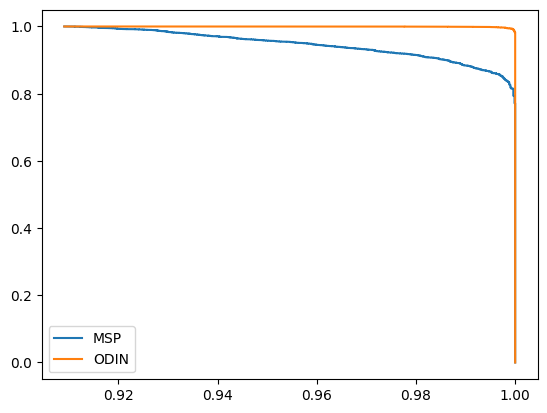

In [60]:
plt.figure()
plt.plot(fpr, tpr, label='MSP')
plt.plot(fpr_odin, tpr_odin, label='ODIN')
plt.legend()

plt.figure()
plt.plot(precision, recall, label='MSP')
plt.plot(precision_odin, recall_odin, label='ODIN')
plt.legend()
plt.show()

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [75]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified


In [76]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [77]:
def fgsm_targeted_attack(model, criterion, image, label, target, epsilon, max_iter=100):
    orig_img = image.clone().detach()
    perturb_img = image.clone().detach().requires_grad_(True)
    target = torch.tensor([target]).to(device)

    if label.item() == target.item():
        return -1, orig_img, perturb_img.detach()

    output = model(perturb_img.unsqueeze(0))
    if output.argmax().item() != label.item():
        return 0, orig_img, perturb_img.detach()
    for i in range(max_iter + 1):
        output = model(perturb_img.unsqueeze(0))
        loss = - criterion(output, target) # Negative Loss between output and target
        if output.argmax().item() == target.item():
            return i, orig_img, perturb_img.detach()

        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturb_img += epsilon * torch.sign(perturb_img.grad)

        perturb_img.requires_grad_(True)

    return None, orig_img, perturb_img.detach()


def show_attack(orig_img, label, adv_img, target, num_iter, inv, classes):
    if num_iter == None:
        print('Attack Failed!')
    elif num_iter == 0:
        print('Already misclassified!')
    elif num_iter == -1:
        print('The target corresponds to the label!')
    else:
        print(f'Attack Success!')
        print(f'Iteration: {num_iter}')
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(inv(orig_img).permute(1,2,0).detach().cpu())
        ax[0].set_title(f'Original - {classes[label]}')
        ax[1].imshow(inv(adv_img).permute(1,2,0).detach().cpu())
        ax[1].set_title(f'Adversarial - {classes[target]}')
        ax[2].imshow(inv(orig_img-adv_img).permute(1,2,0).detach().cpu())
        ax[2].set_title('Difference')
        plt.show()

Already misclassified!


Attack Success!
Iteration: 32


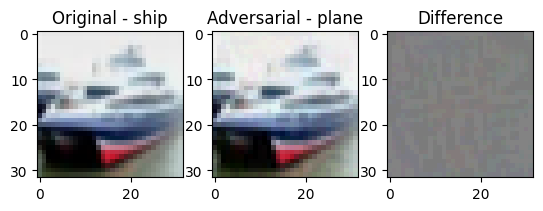

Attack Success!
Iteration: 16


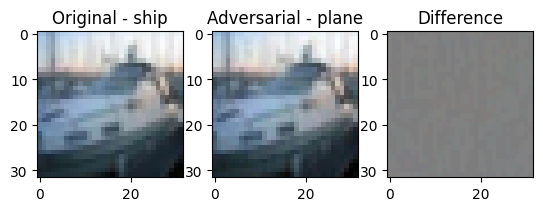

The target corresponds to the label!
Already misclassified!


Attack Success!
Iteration: 44


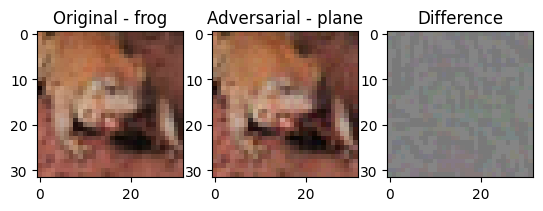

Already misclassified!


Attack Success!
Iteration: 42


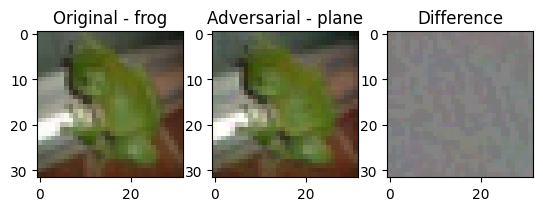

Attack Success!
Iteration: 39


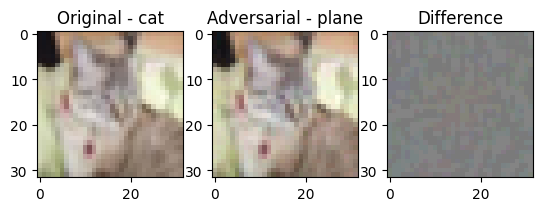

Attack Success!
Iteration: 50


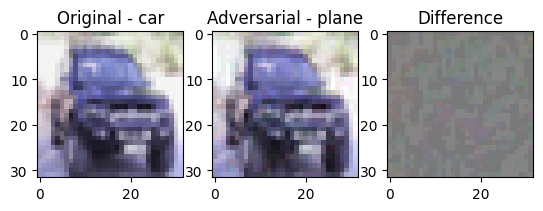

The target corresponds to the label!


Attack Success!
Iteration: 68


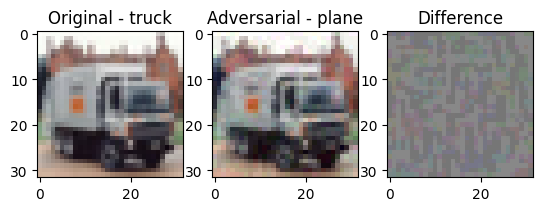

Attack Success!
Iteration: 45


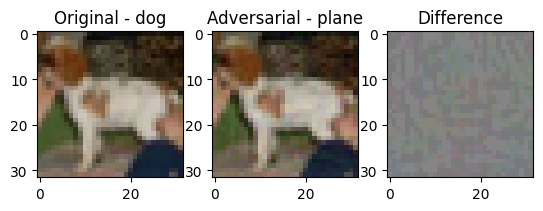

Attack Success!
Iteration: 53


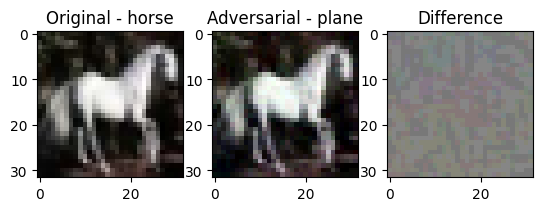

Attack Success!
Iteration: 61


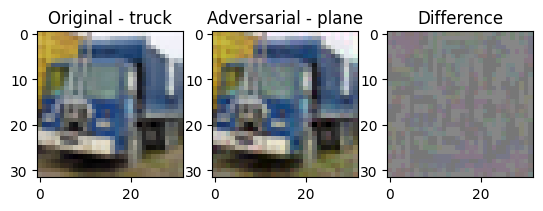

Attack Success!
Iteration: 55


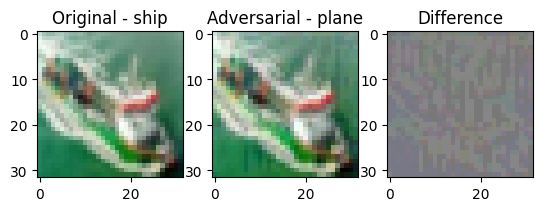

In [ ]:
epsilon = 0.001
batch_size = 16
target = 0
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model.eval()

img, label = next(iter(testloader))
for i in range(batch_size):
    img_ex, label_ex = img[i].to(device), label[i].to(device)
    num_iter, orig_img, adv_img = fgsm_targeted_attack(model, criterion, img_ex, label_ex, target, epsilon)
    show_attack(orig_img, label_ex, adv_img, target, num_iter, inv, classes)


In [86]:
# EVALUATE ASR VERSUS EPSILON
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
target = 0
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asrt_eps = []
for epsilon in epsilons:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img = fgsm_targeted_attack(model, criterion, img, label, target, epsilon, max_iter=10)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asrt_eps.append(num_success/num_attacks)
    print(f'Epsilon: {epsilon} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified
Epsilon: 0.001 - Attack Success Rate: 0.15477792732166892
Epsilon: 0.005 - Attack Success Rate: 0.2578444747612551
Epsilon: 0.01 - Attack Success Rate: 0.4903314917127072
Epsilon: 0.02 - Attack Success Rate: 0.885952712100139
Epsilon: 0.05 - Attack Success Rate: 1.0
Epsilon: 0.1 - Attack Success Rate: 1.0


In [84]:
# EVALUATE ASR VERSUS EPSILON
epsilon = 0.001
max_iters = [10, 20, 50, 100]
target = 0
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asrt_iters = []
for max_iter in max_iters:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img = fgsm_targeted_attack(model, criterion, img, label, target, epsilon, max_iter)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asrt_iters.append(num_success/num_attacks)
    print(f'Max Iterations: {max_iter} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max Iterations: 10 - Attack Success Rate: 0.14986376021798364
Max Iterations: 20 - Attack Success Rate: 0.15214384508990317
Max Iterations: 50 - Attack Success Rate: 0.24517906336088155
Max Iterations: 100 - Attack Success Rate: 0.4966078697421981


Text(0.5, 1.0, 'Attack Success Rate vs Max Iterations, epsilon=0.01')

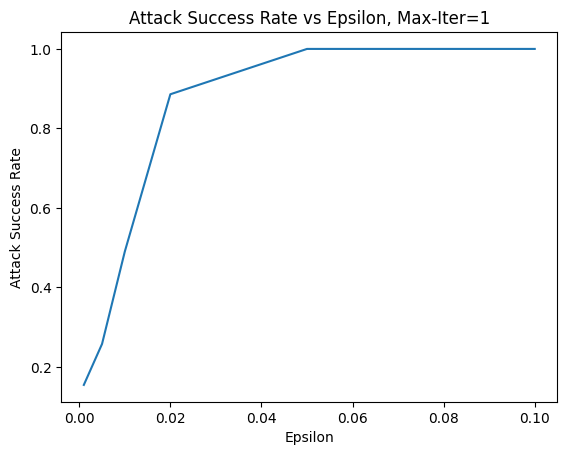

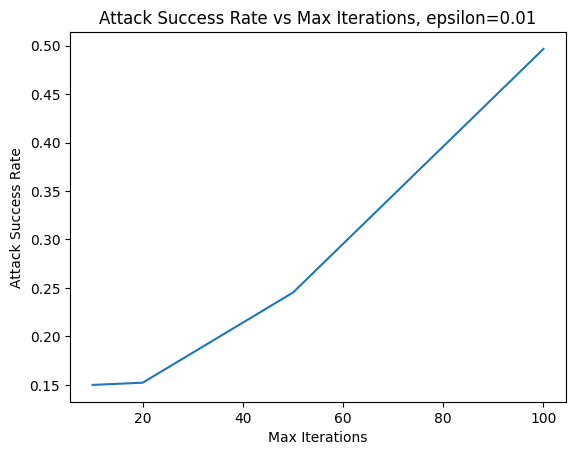

In [87]:
plt.figure()
plt.plot(epsilons, asrt_eps, label='CIFAR-10 Training')
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Epsilon, Max-Iter=1')

plt.figure()
plt.plot(max_iters, asrt_iters, label='CIFAR-10 Training')
plt.xlabel('Max Iterations')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Max Iterations, epsilon=0.01')
